In [1]:
pip install pyometiff

In [2]:
import os

from scipy.stats import ttest_ind
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pyometiff
import pandas as pd
import seaborn as sns
from google.colab import drive
from sklearn.mixture import GaussianMixture

In [3]:
PATH_TO_FOLDER = os.path.join('..', 'd4l')
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')

drive.mount('/content/drive')
PATH_TO_FOLDER = '/content/drive/My Drive/MAGISTERKA/DL'
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')


if PATH_TO_FOLDER is None:
    raise ValueError('Please set PATH_TO_FOLDER to a path with unzipped training data.')

ANNDATA_PATH = 'cell_data.h5ad'
TRAIN_ANNDATA_PATH = os.path.join(TRAIN_DATA_PATH, ANNDATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)

markers = train_anndata.var['marker']
expressions_df = pd.DataFrame(train_anndata.layers["exprs"], columns=markers)
all_data = pd.concat([train_anndata.obs.reset_index(), expressions_df], axis=1)

In [6]:
tumor_data = all_data[all_data['celltypes'] == 'Tumor']
mac_data = all_data[all_data['celltypes'] == 'MacCD163']

#**Biologically driven patterns of intertype marker differentiation**

####The function adds labels to the dataframe based on Gaussian Mixture Model clustering for a specific marker. It helps visualize the distribution of models where a given marker is overexpressed compared to where it is underexpressed.####




In [7]:
def add_labels(marker, data):
    gmm = GaussianMixture(n_components=2, random_state=0).fit(data[[marker]])
    label = marker + '_LABEL'
    data[label] = gmm.predict(data[[marker]])

    val_1 = data.loc[data[label] == 1, marker].iloc[0]
    val_0 = data.loc[data[label] == 0, marker].iloc[0]

    if val_1 < val_0:
      data[label] = data[label].replace({0: 1, 1: 0})

In [8]:
add_labels('PDL1', tumor_data)
add_labels('Ki67', tumor_data)
add_labels('cleavedPARP', tumor_data)

<ipython-input-7-fb00ac540d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = gmm.predict(data[[marker]])
<ipython-input-7-fb00ac540d3f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = data[label].replace({0: 1, 1: 0})
<ipython-input-7-fb00ac540d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

<Axes: xlabel='PDL1', ylabel='Count'>

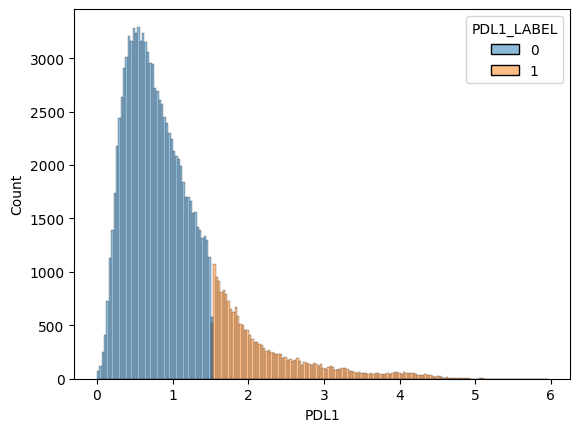

In [9]:
sns.histplot(data=tumor_data, x="PDL1", hue="PDL1_LABEL")

<Axes: xlabel='Ki67', ylabel='Count'>

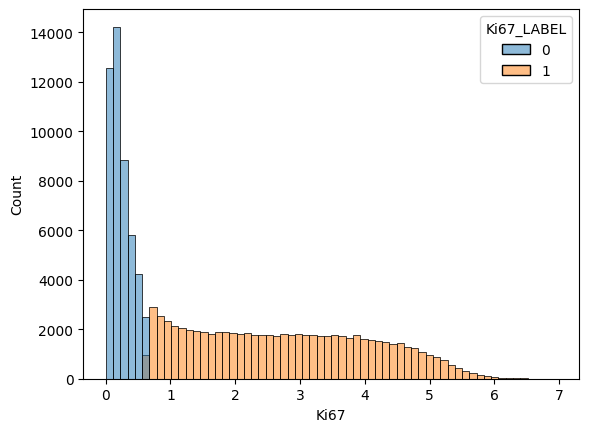

In [10]:
sns.histplot(data=tumor_data, x="Ki67", hue="Ki67_LABEL")

<Axes: xlabel='cleavedPARP', ylabel='Count'>

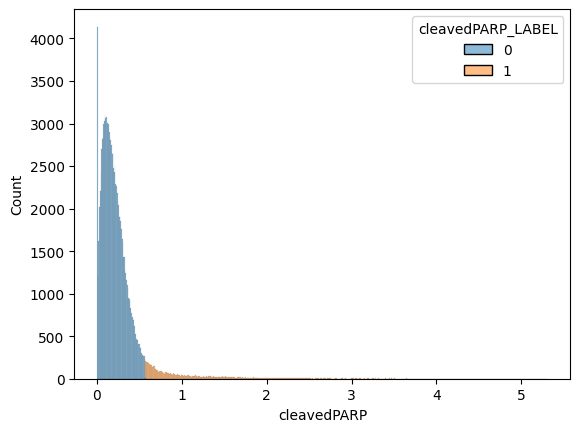

In [11]:
sns.histplot(data=tumor_data, x="cleavedPARP", hue="cleavedPARP_LABEL")

<ipython-input-7-fb00ac540d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = gmm.predict(data[[marker]])


<Axes: xlabel='CD206', ylabel='Count'>

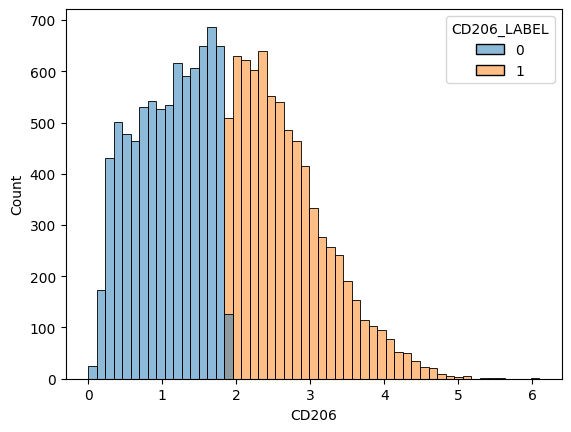

In [12]:
add_labels("CD206", mac_data)

sns.histplot(data=mac_data, x="CD206", hue="CD206_LABEL")

####This function generates a visualization illustrating the mean expression levels of all markers in a given cell type compared to a specified label expression in this cell type (positive "+" or negative "-"). It standardizes the labels to indicate marker presence or absence, calculates mean expression values for each marker within the groups defined by the label, and then visualizes the data using a clustermap. The data is normalized with z-score centering.

In [20]:
markers = ['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
           'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
           'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
           'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
           'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
           'DNA2']


def create_expression_heatmap(label, celltype, data):

  def map_label(value, celltype, label):
    if value == 0:
      return f"{celltype}_{label.split('_')[0]}-"
    elif value == 1:
      return f"{celltype}_{label.split('_')[0]}+"
    else:
      return value

  data[label] = data[label].apply(map_label, args=(celltype,label))

  # Calculating the mean expression levels for each marker within a given cell type.
  mean_expressions = {}
  label_grouped = data.groupby(label)
  label_means = label_grouped[markers].mean()
  mean_expressions[label] = label_means

  mean_expressions_df = pd.concat(mean_expressions.values(), keys=mean_expressions.keys())
  cluster_grid = sns.clustermap(mean_expressions_df.T, z_score=0, center=0, yticklabels=mean_expressions_df.columns,
               cmap="seismic", col_cluster=False)

  cluster_grid.ax_heatmap.set_title(f"Heatmap of mean marker expression in {celltype} type of cells vs {label.split('_')[0]}")
  cluster_grid.ax_heatmap.set_ylabel("Markers")
  cluster_grid.ax_heatmap.set_xlabel(f"{label.split('_')[0]} expression in {celltype} cell")
  #print(mean_expressions_df.T)

<ipython-input-20-dd9a8742b0f4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = data[label].apply(map_label, args=(celltype,label))


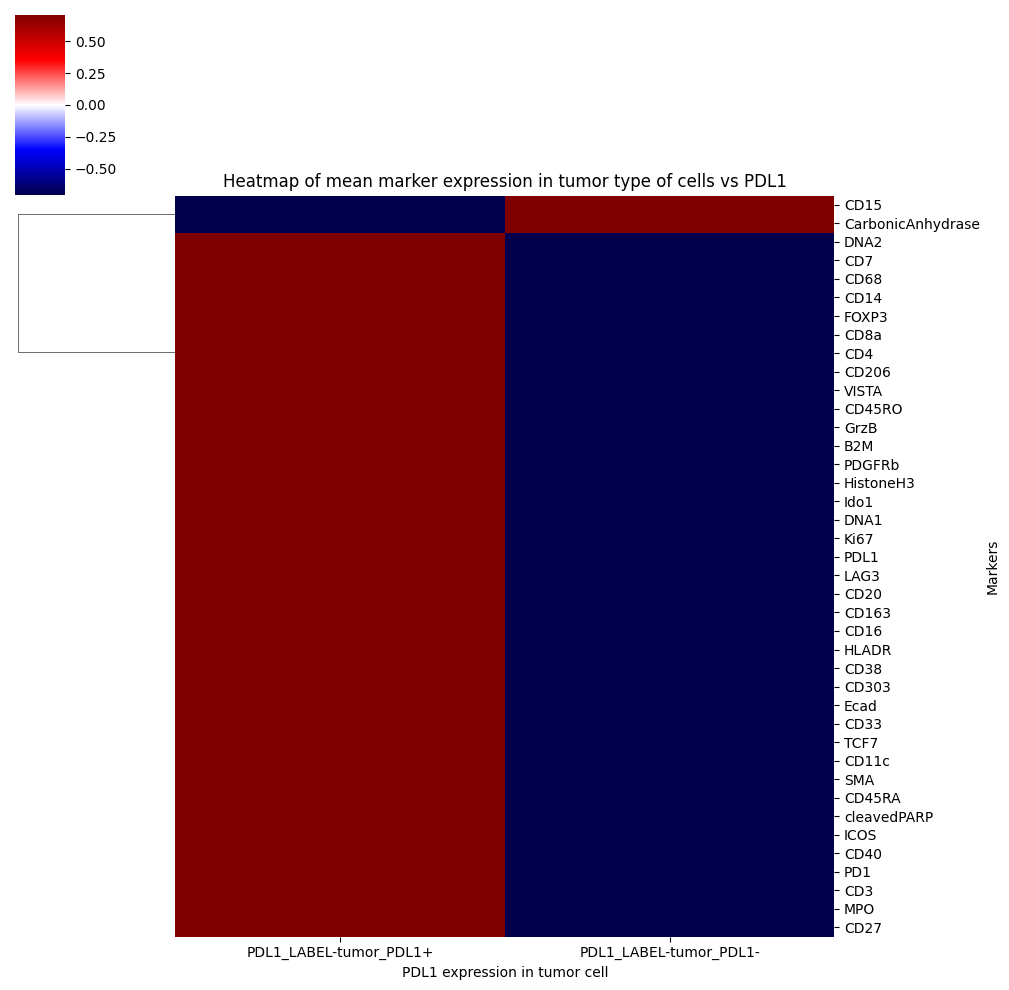

In [21]:
create_expression_heatmap('PDL1_LABEL', 'tumor', tumor_data)

## TumorPDL1- vs TumorPDL1+

- The elevated expression of immune activation markers in PDL1+ tumors suggests a more robust antitumor immune response. This may indicate that PDL1 expression in tumors could serve as a marker of ongoing immune surveillance and response against tumor cells. Conversely, the lower expression of these markers in PDL1- tumors raises questions about the extent of immune activation and its impact on tumor progression in these contexts.
- The higher expression of proliferation markers such as Ki67 in PDL1+ tumors implies increased cellular proliferation within the tumor microenvironment. This could contribute to tumor growth and expansion in PDL1+ tumors compared to PDL1- tumors, where lower Ki67 expression suggests reduced proliferative activity. Understanding the factors driving differential proliferation rates between PDL1+ and PDL1- tumors could provide insights into tumor dynamics and therapeutic vulnerabilities.
- The altered expression of markers like CD15 and Carbonic Anhydrase in PDL1- tumors suggests potential differences in tumor-stroma interactions and microenvironmental conditions. These markers may be indicative of specific cell types or metabolic processes that influence the tumor microenvironment's composition and function.
- The distinct molecular profiles of PDL1+ and PDL1- tumors raise the possibility of tailored therapeutic approaches. Targeting pathways associated with immune activation and proliferation may be particularly effective in PDL1+ tumors, while strategies aimed at modulating the tumor microenvironment could be more beneficial in PDL1- tumors. Additionally, these findings underscore the importance of comprehensive biomarker profiling in guiding personalized treatment strategies for cancer patients.

<ipython-input-20-dd9a8742b0f4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = data[label].apply(map_label, args=(celltype,label))


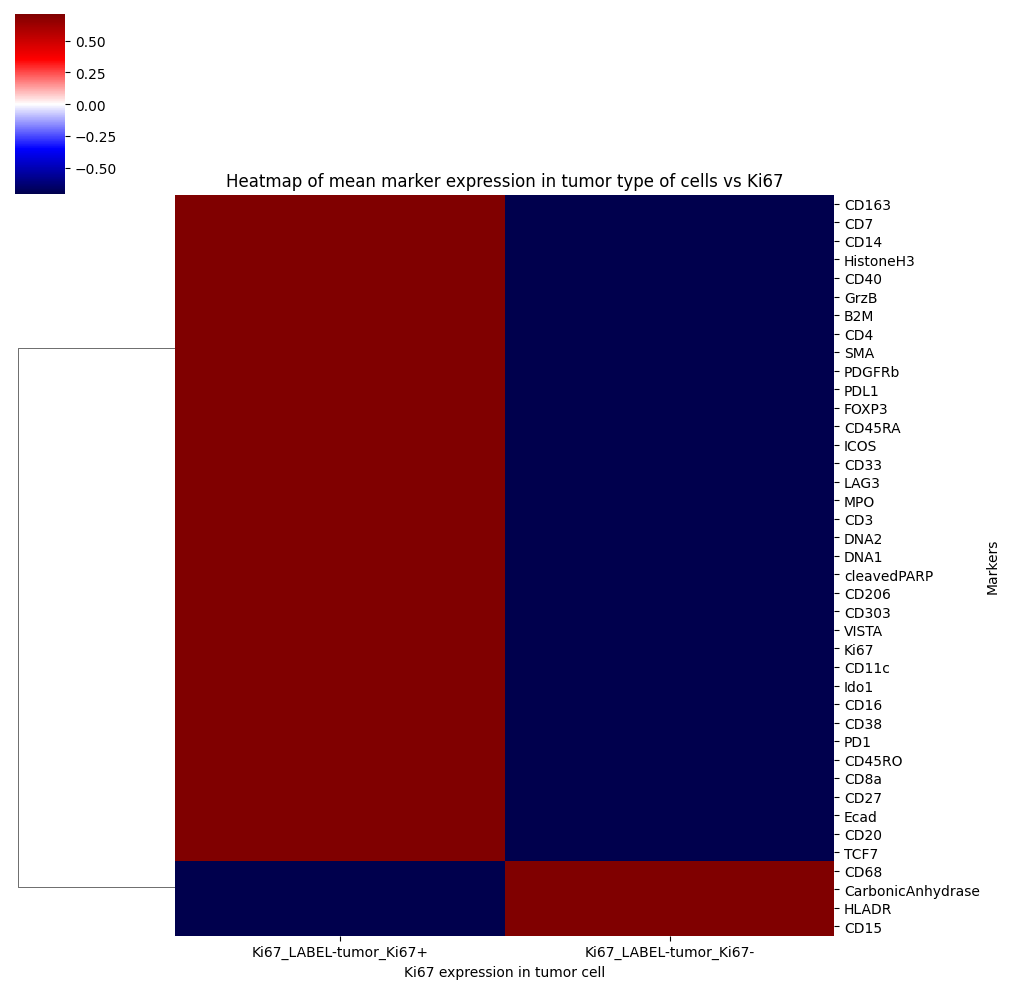

In [22]:
create_expression_heatmap('Ki67_LABEL', 'tumor', tumor_data)

##TumorKi67- vs TumorKi67+

- Most markers, including Ki67, show lower expression compared to Tumor ki67+. Exceptions are CD68, CD15, and CarbonicAnhydrase, which exhibit higher expression in Tumor ki67-. Possible explanations include the presence of a subpopulation of more mature cells with lower proliferative activity, as well as potential changes in the microenvironment stimulating intercellular interactions.

- In the case of Tumor ki67-, we also observe higher expression of HLADR compared to Tumor ki67+. HLADR is associated with the activation of immune cells, especially macrophages, and has the ability to present antigens. The higher expression of HLADR in Tumor ki67- may indicate increased activity of immune cells, which could be associated with attempts to control tumor growth by the immune system. However, the precise mechanisms and implications of this difference in HLADR expression require further investigation.

- These observations suggest that differences in marker expression between Tumor ki67+ and Tumor ki67- may reflect disparities in proliferative activity and immune reactivity in these two tumor subtypes. However, additional research is necessary to better understand the mechanisms responsible for these differences and their clinical implications.

<ipython-input-20-dd9a8742b0f4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = data[label].apply(map_label, args=(celltype,label))


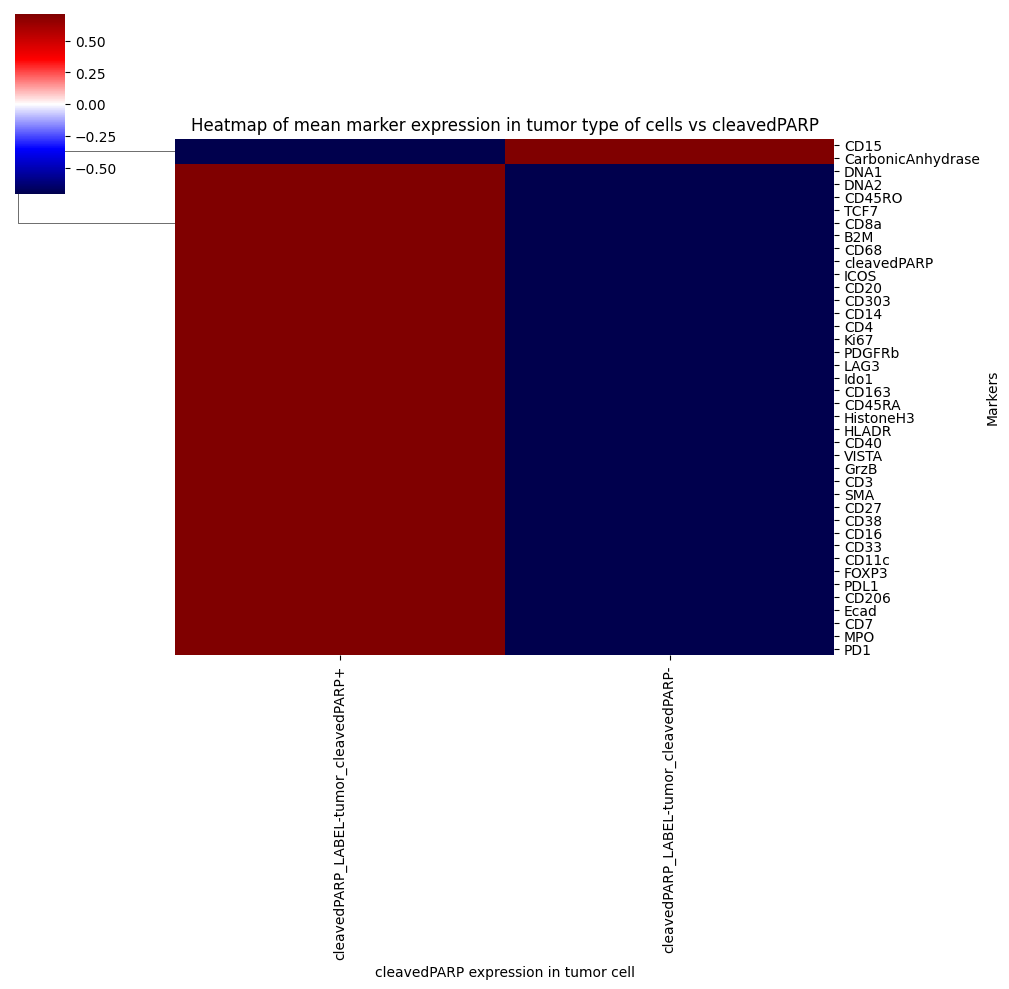

In [23]:
create_expression_heatmap('cleavedPARP_LABEL', 'tumor', tumor_data)

## Tumor_cleavedPARP- vs Tumor_cleavedPARP+

- In the case of Tumor cleavedPARP+, we observe higher expression levels of most markers compared to Tumor cleavedPARP-. The marker cleavedPARP, which serves as a reference point for the groups, shows higher expression in this group, which may indicate greater apoptotic activity in the cells of Tumor cleavedPARP+. Additionally, markers such as Ki67, CD33, Ecad, DNA1, and DNA2, which are associated with cell proliferation and potential tumorigenic processes, also exhibit higher expression in this group. Possible explanations include activation of apoptotic pathways and increased proliferation of tumor cells in Tumor cleavedPARP+.

- In Tumor cleavedPARP-, we observe lower expression of most markers compared to Tumor cleavedPARP+. However, the markers CD15 and CarbonicAnhydrase show higher expression in this group. This may indicate the presence of a subpopulation of more mature cells or changes in the microenvironment conducive to intercellular interactions, which may be associated with apoptotic processes and cell migration in Tumor cleavedPARP-.

<ipython-input-13-a9d0ed2b22a0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = data[label].apply(map_label, args=(celltype,label))


                  CD206_LABEL           
CD206_LABEL        Mac_CD206+ Mac_CD206-
MPO                  0.264846   0.257718
HistoneH3            2.481014   2.478355
SMA                  0.614342   0.533438
CD16                 1.986766   1.856681
CD38                 0.399405   0.387270
HLADR                3.786336   3.593607
CD27                 0.721345   0.671545
CD15                 0.968561   1.007867
CD45RA               0.562051   0.505047
CD163                2.653255   2.035391
B2M                  2.194647   2.207600
CD20                 0.556051   0.495252
CD68                 2.888202   2.613182
Ido1                 1.107959   1.073281
CD3                  0.748190   0.704370
LAG3                 0.297267   0.291913
CD11c                1.943971   2.129735
PD1                  0.489543   0.473233
PDGFRb               1.319174   1.195608
CD7                  0.997956   0.888339
GrzB                 1.178548   1.103353
PDL1                 0.900132   0.847049
TCF7            

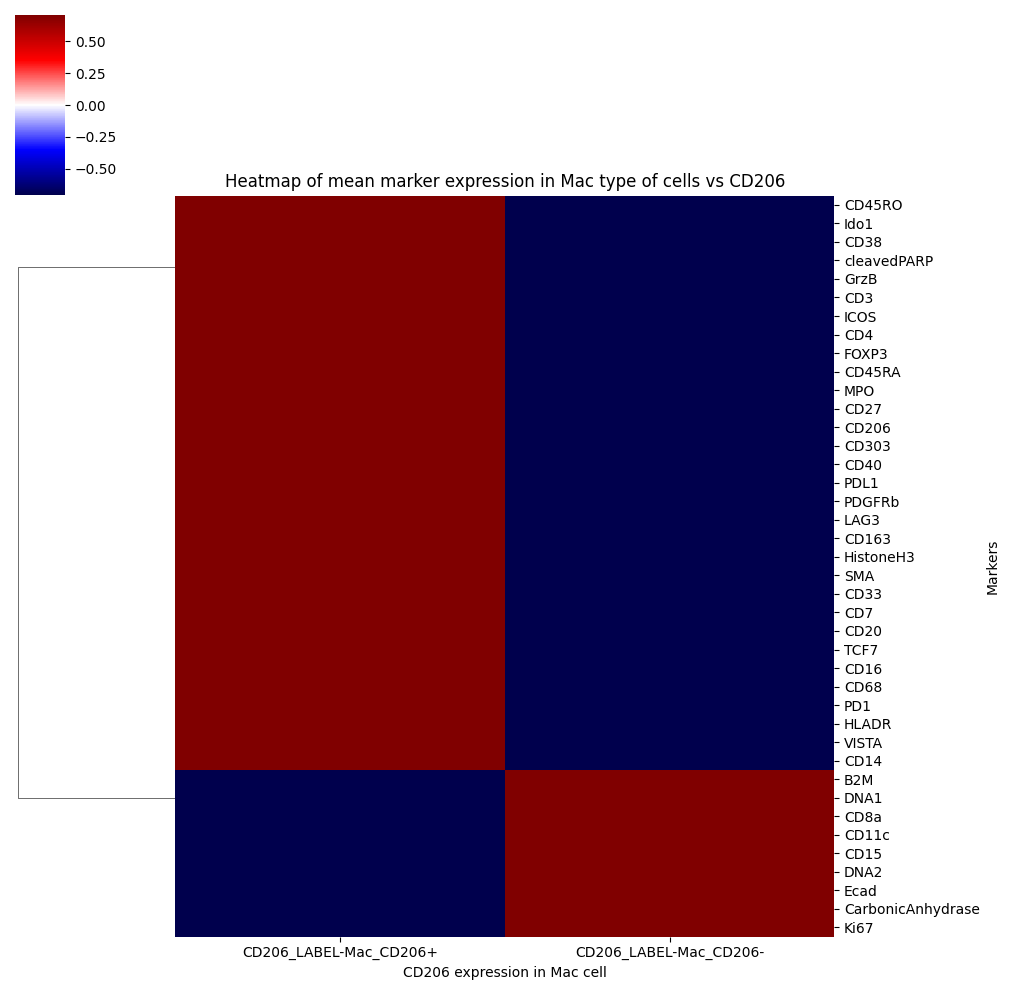

In [17]:
create_expression_heatmap('CD206_LABEL', 'Mac', mac_data)

##**MacCD206- vs MacCD206-**

- For MacCD206+, we observe higher expression of most markers compared to MacCD206-. This may suggest that MacCD206+ cells exhibit a more active immunological phenotype, potentially reflecting their role in regulating immune responses and antigen presentation. Additionally, higher expression of dendritic cell-related markers such as HLADR, CD11c, and CD206 may indicate their involvement in antigen presentation and interaction with T lymphocytes.

- In the case of MacCD206-, we observe lower expression of most markers compared to MacCD206+, suggesting a potential difference in biological activity between these two cell subtypes. The lower expression of macrophage-related markers such as CD68 and CD163 may indicate a decreased number of macrophage cells or their activity in the tumor microenvironment of MacCD206-. Furthermore, lower expression of immunological markers such as HLADR, CD11c, and CD206 suggests limited activation of antigen-presenting cells and interaction with T lymphocytes in this population.

- Of particular interest is the higher expression of cell proliferation markers such as Ki67, DNA1, and DNA2 in MacCD206-. This suggests the possibility of increased cell proliferation in this population, which may impact tumor development dynamics and therapy response. Additionally, higher expression of markers such as CD15, CD8a, CD11c, and CarbonicAnhydrase may indicate the presence of a more mature cell subpopulation or changes in the microenvironment favoring intercellular interactions associated with apoptotic processes and cell migration in MacCD206-.